# 6.1. RNN의 문제점

- 시계열 데이터의 장기 의존 관계를 학습하기 어려움(장기 기억에 취약)

## 6.1.2. 기울기 소실 or 기울기 폭발

- 

# 6.4. LSTM을 사용한 언어 모델

* 언어모델 구현 하기
* Time RNN 계층 -> Time LSTM 계층 사용
* (그림 6-26) 왼쪽: Time RNN  //  오른쪽: Time LSTM

---

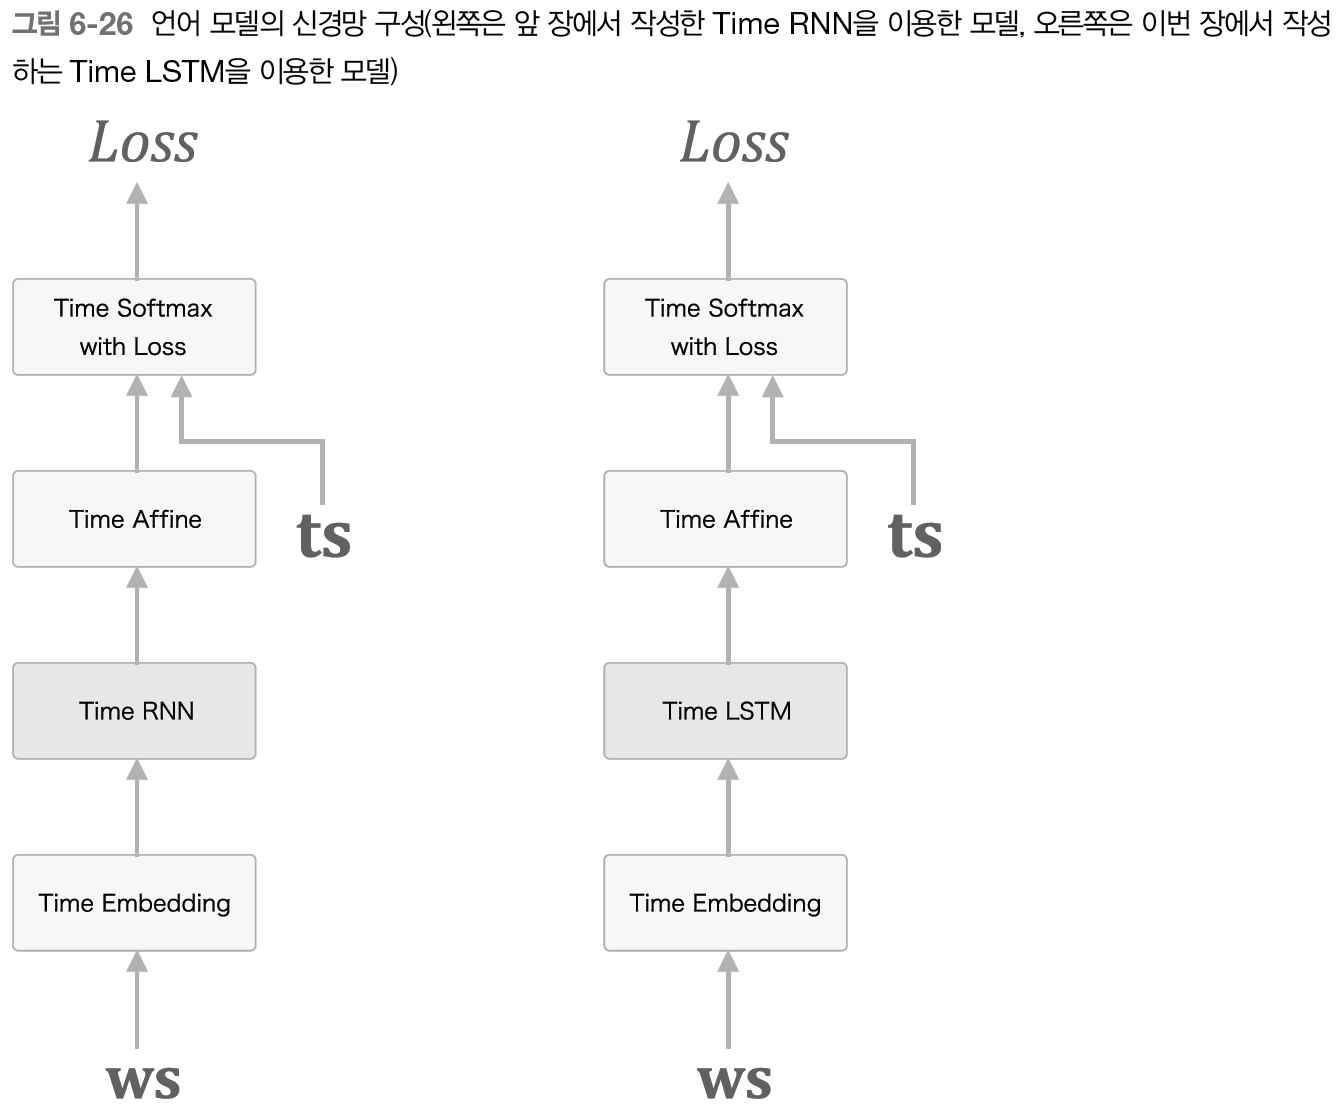

---

<br/><br/>

## [ LSTM 계층을 사용하는 Rnnlm 클래스 구현 ]  👇

#### - `predict( )` 메서드 추가: softmax 계층 직전까지 처리
#### - `load_params( )`, `save_params( )`메서드 추가: 매개변수 읽기 / 쓰기 -> BaseModel 클라스
---

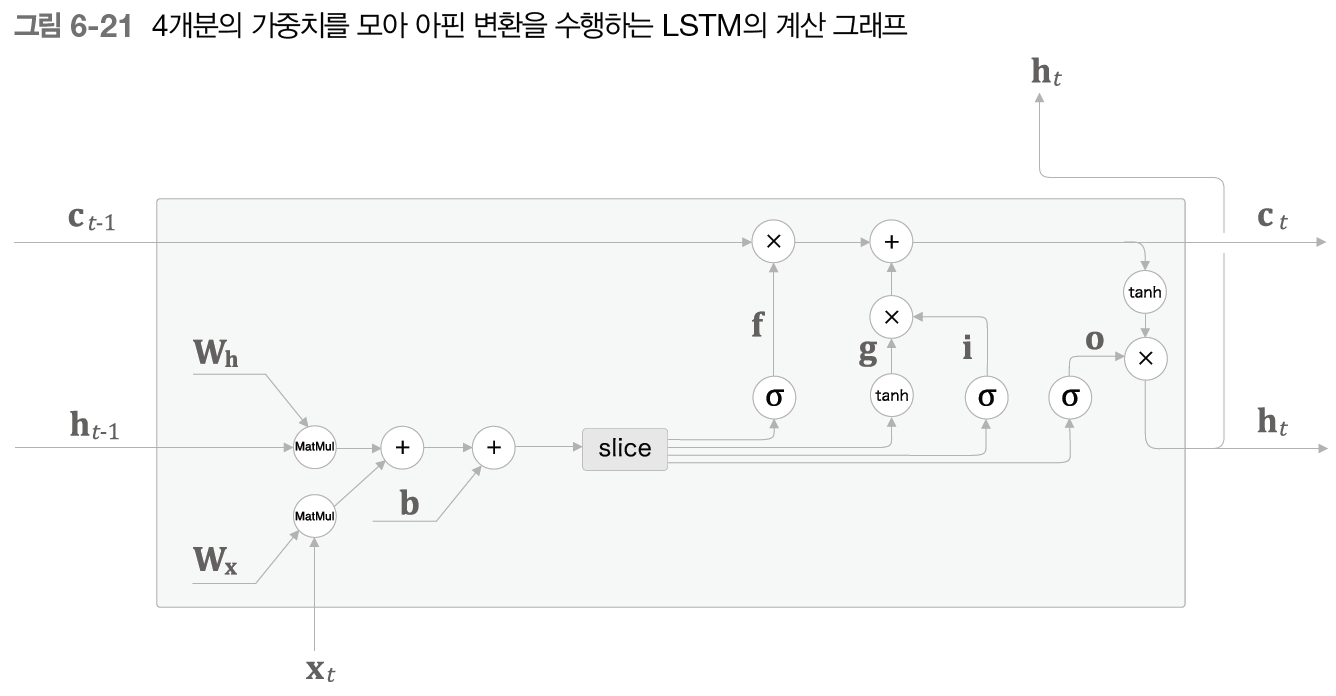

---

In [ ]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle
# (*) -------------------------------------------
from common.base_model import BaseModel
# (*) -------------------------------------------


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        # (**) ----------------------------------------------------
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        # (**) ----------------------------------------------------
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

 # (***) ----------------------------------------
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
 # (***) ----------------------------------------

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
   
 # (*) ------------------------------------------------- 

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
            
 # (*) -------------------------------------------------


## [ (위 신경망을 이용해) PTB 데이터셋 학습 ] 👇

In [ ]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25    # 기울기 클리핑

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]     # 입력
ts = corpus[1:]      # 출력 (정답레이블)

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)    # Rnnlm Trainer 클래스를 사용하여 모델을 학습
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# (1) 기울기 클리핑(max_grad)을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, # fit(): 모델의 기울기를 구해 매개변수 갱신
            eval_interval=20)  # 20번째 반복마다 퍼플렉서티를 평가하라는 뜻
trainer.plot(ylim=(0, 500))    # 결과를 그래프로 나타냄

# (2) 테스트 데이터로 평가: 학습 후 테스트 데이터를 사용해 퍼플렉서티를 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)  # [주의!!] 모델 상태(LSTM의 은닉 상태와 기억 셀)를 재설정하여 평가를 수행
print('테스트 퍼플렉서티: ', ppl_test)

# (3) 매개변수 저장
model.save_params()

### [ 참고: Rnnlm Trainer 클래스의 `fit( )의 내부` ] 👇

In [ ]:
# 기울기 구하기
model.forward(...)
model.backward(...)
params, grads = model.params, model.grads

# 기울기 클리핑
if max_grad is no None:
    clip_grads(grads, max_grad)  # 6.1.4 기울기 폭발 대책 참고
    
# 매개변수 갱신
optimizer.update(params, grads)

## (1) 기울기 클리핑(max_grad)을 적용하여 학습

#### - eval_interval=20: 20번째 반복마다 퍼플렉서티를 평가하라는 뜻
#### - 데이터가 크기 때문에 모든 에폭에서 평가하지 않고 20번 반복될 때마다 평가

---

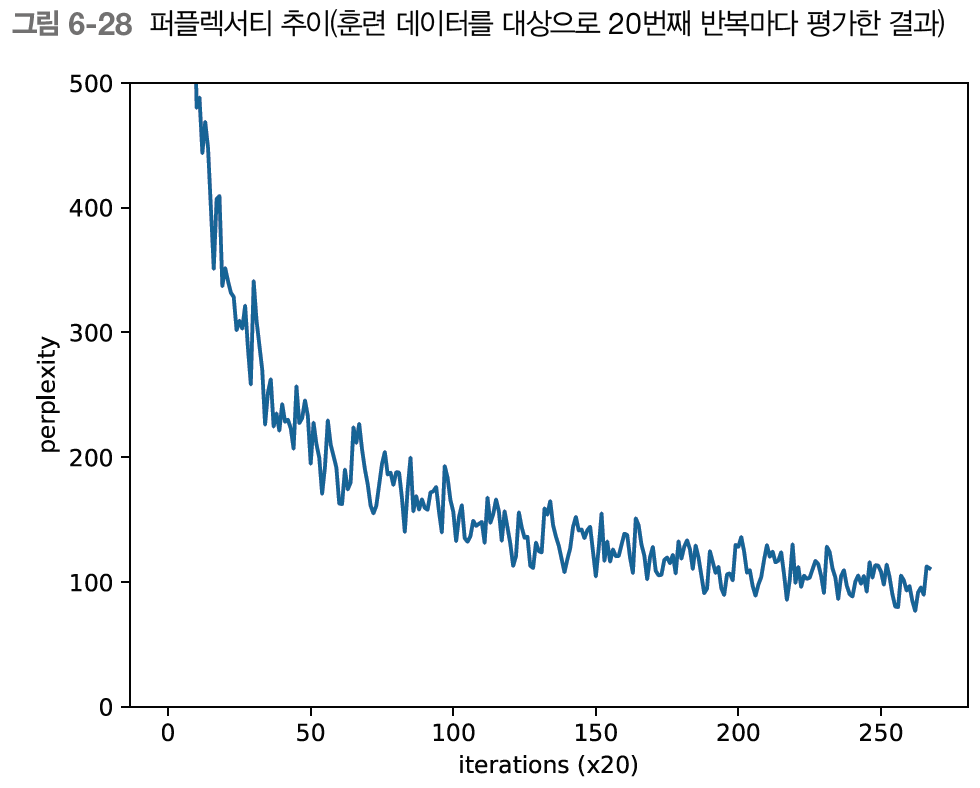

---


<br/><br/>


## (2) 테스트 데이터로 평가

#### [주의!!] 모델 상태(LSTM의 은닉 상태와 기억 셀)를 재설정하여 평가를 수행 -> 어디??
#### - eval_perplexity( ) 메서드 함수는 맨 마지막 첨부


<br/><br/>


## (3) 학습이 완료된 매개변수 저장

#### 다음 장의 학습된 가중치 매개변수를 사용해 문장을 생성할 때 이 파일 사용


<br/><br/>

---

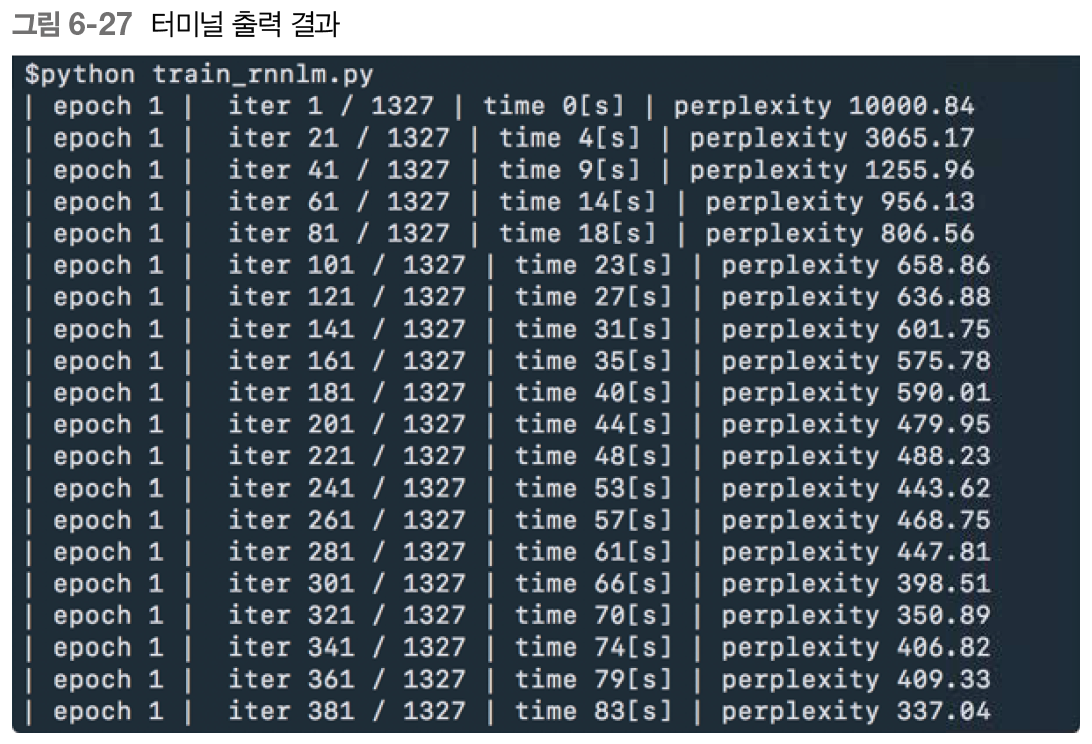

#### * 모델이 아직 더 개선할 여지가 많음 => 현재의 RNNLM을 더욱 개선해보자!!

---

# 6.5. RNNLM 추가 개선

- 언어 모델(RNNLM) 개선 포인트 3가지 : **`LSTM 계층 다층화` / `drop out에 의한 과적합 억제` / `가중치 공유`**

<br/><br/>


## 6.5.1. LSTM 계층 다층화

#### -  LSTM 계층 깊게 쌓기 (feedforward 신경망에서 계층을 깊게 쌓을수록 모델 표현력이 좋아진 것처럼)

#### - 층의 깊이(하이퍼파라미터)는 처리할 문제의 복잡도나 준비된 학습 데이터의 양에 따라 결정

#### - 예) PTB 데이터셋의 언어 모델: 2~4층 / GNMT 모델(구글 번역에서 사용): 8층

---

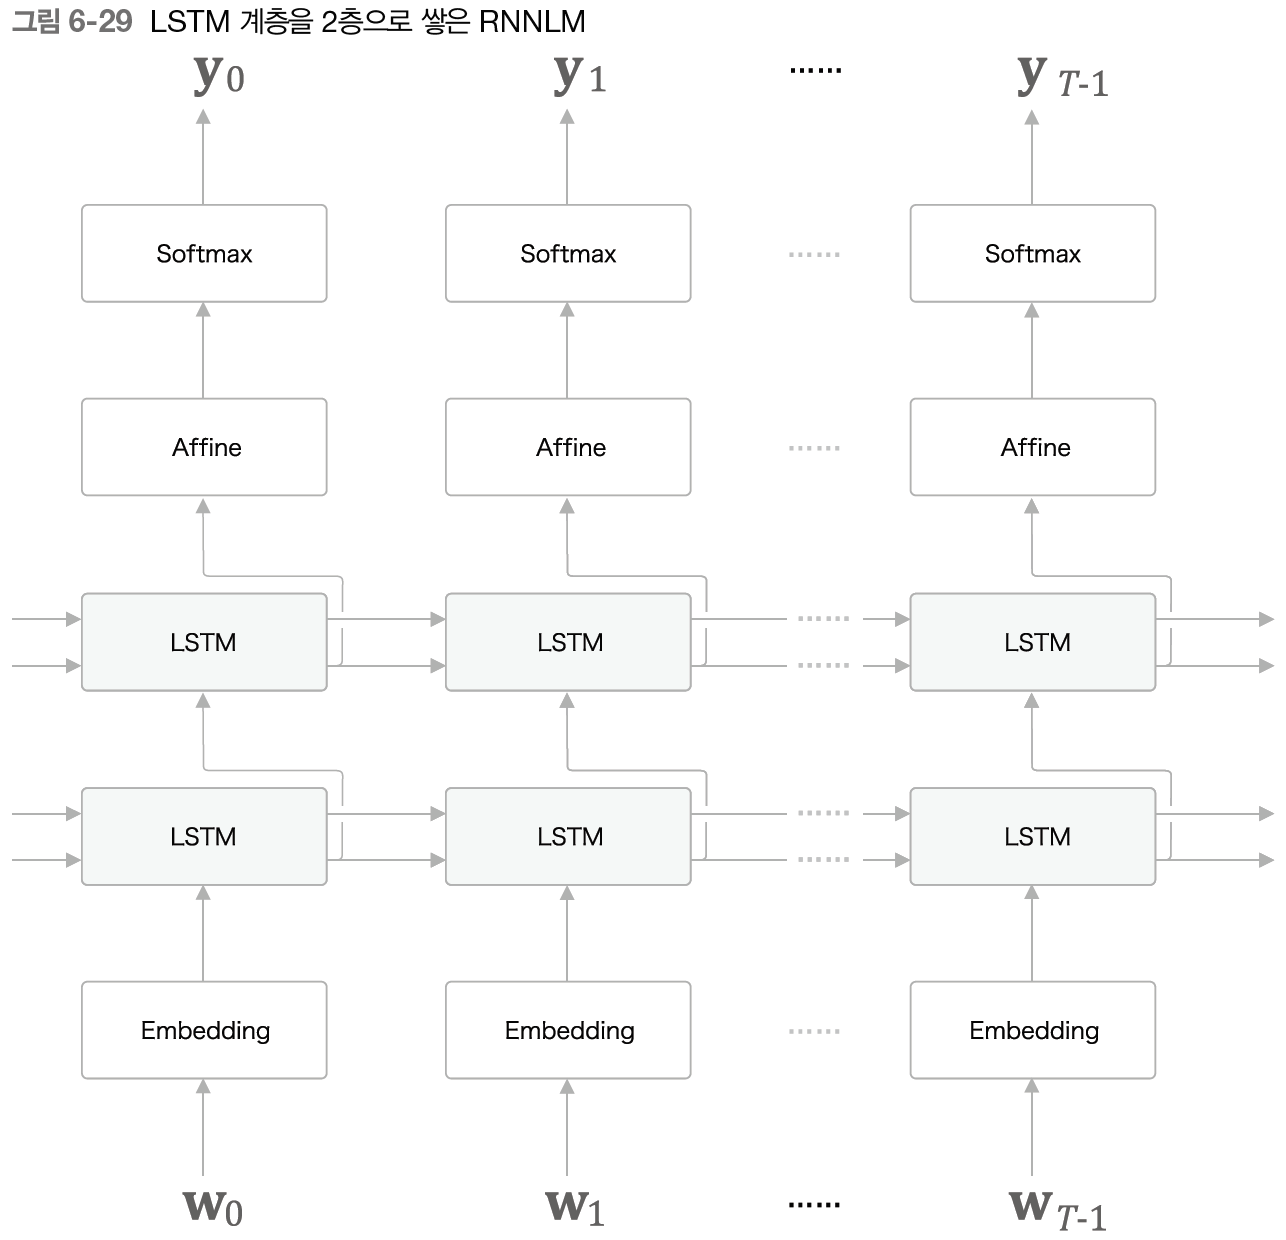

---

<br/><br/>


## 6.5.2. drop out에 의한 과적합 억제

### - 6.5.1. 계층 다층화가 과적합을 일으킬 수 있음. 게다가 RNN은 일반적인 feedforward 신경망보다 쉽게 과적합을 일으킴.

### * 과적합 억제의 전통적 방법: `훈련 데이터의 양 늘리기`, `모델의 복잡도 줄이기`, `정규화` 등

### - 모델의 복잡도에 페널티를 주는 `정규화` $\supset$ 훈련시 계층 내의  뉴런 몇개를 무작위로 무시하고 학습하는 방법인 `dropout`

---

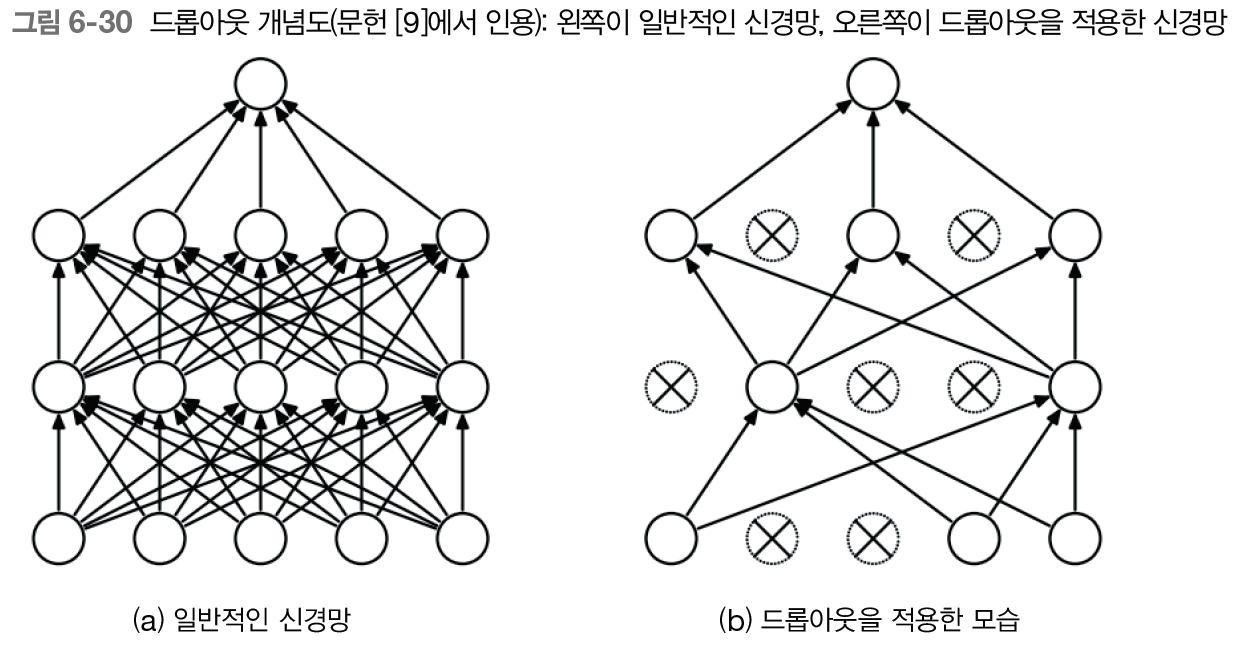

---

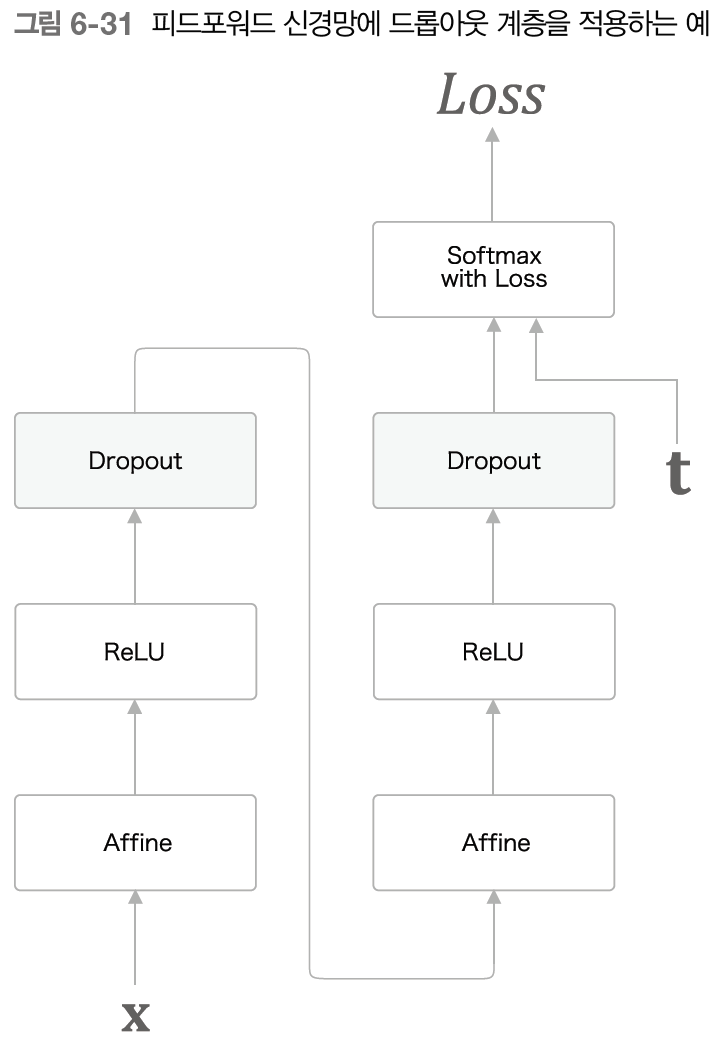

---

### * dropout: feedforward는 활성화 함수 뒤에 삽입 /  RNN에서는 (시계열 방향이 아닌) 깊이 방향(상하 방향)으로 삽입

### - 시계열방향으로 삽입하면 학습시 시간이 흐름에  따라 정보가 사라질 수 있음(흐르는 시간에 비례해 드롭아웃에 의한 노이즈 축적)
###    => 시간축과 독립적임     

---

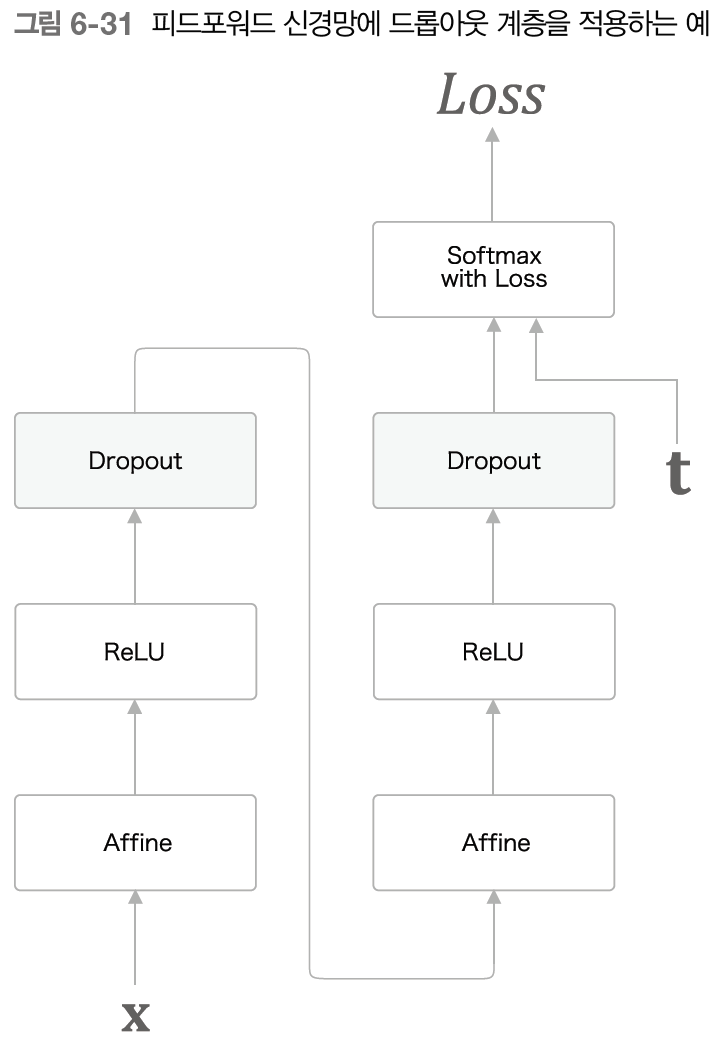

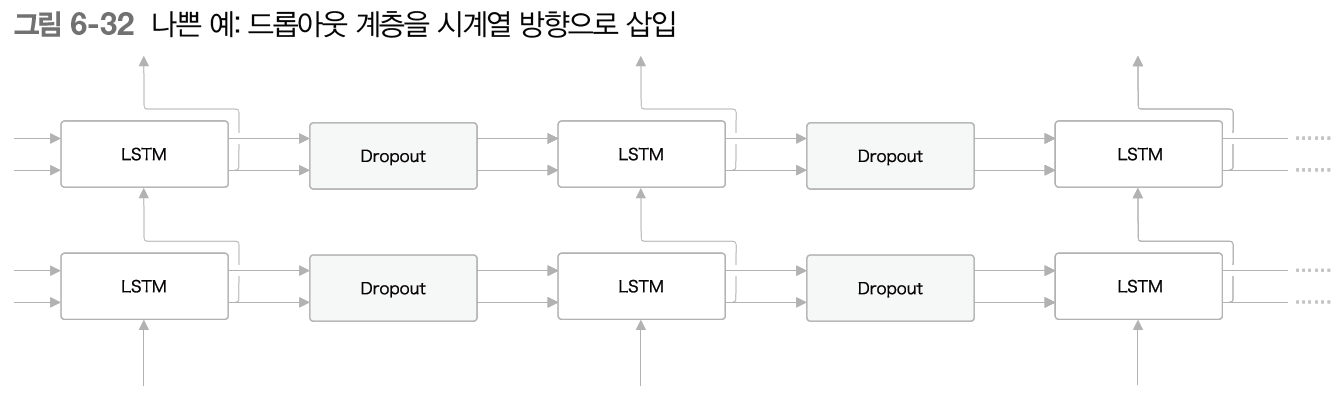

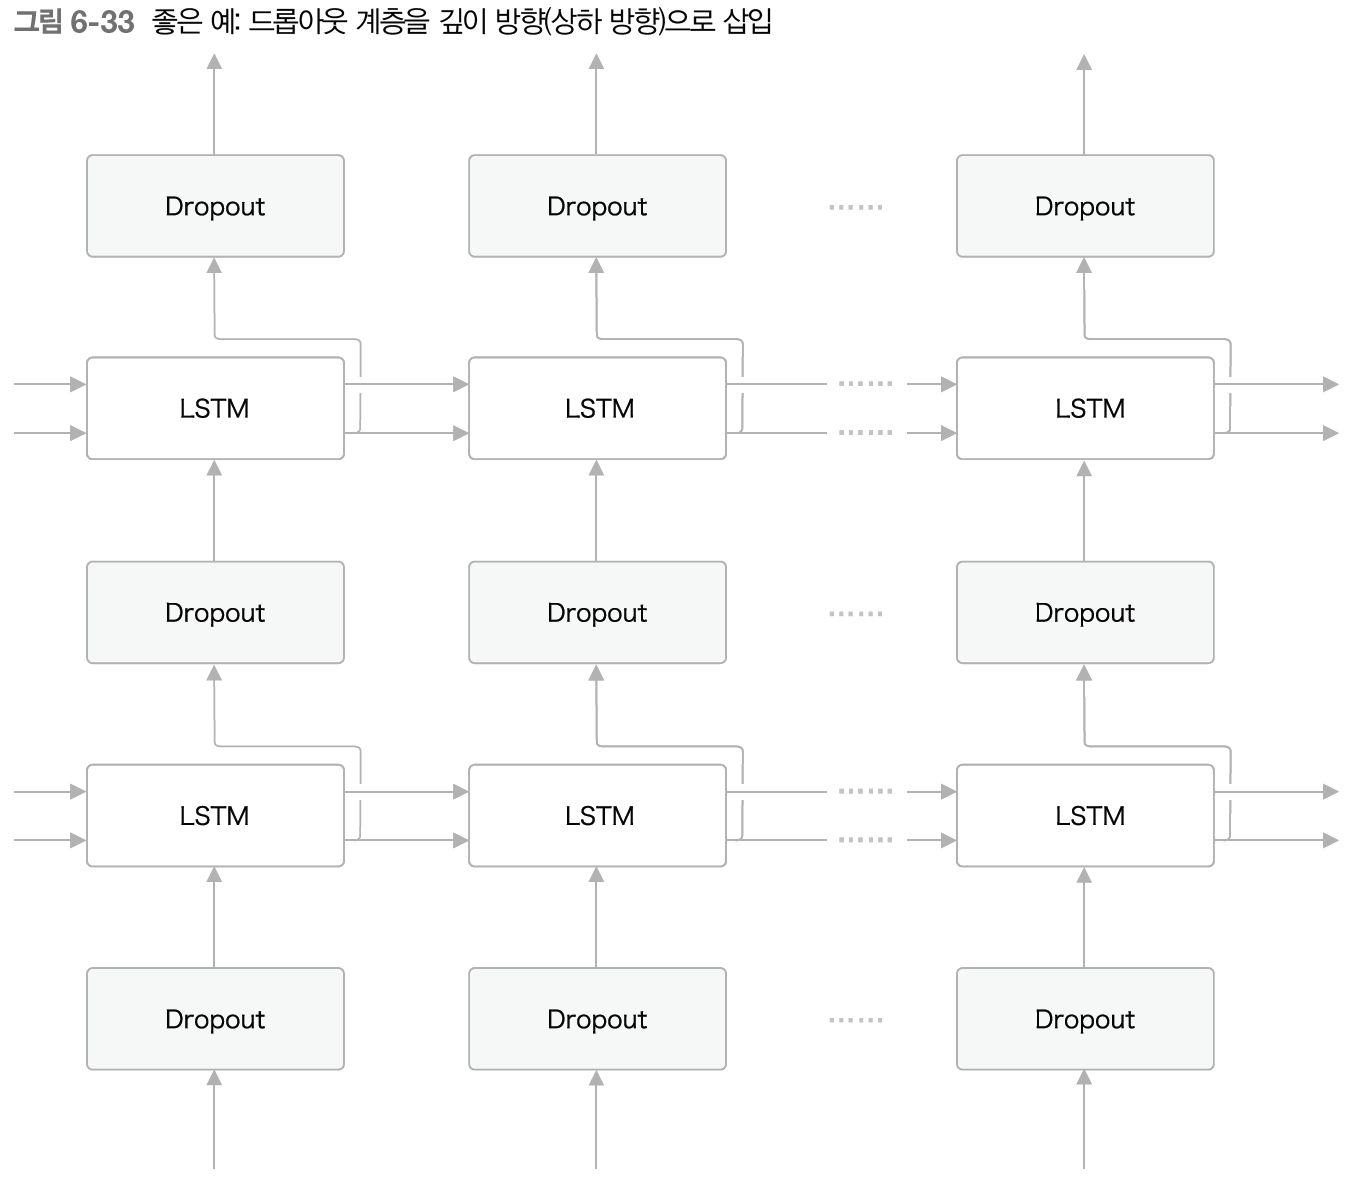

---

### * 결국 feedforward 신경망이나 RNN 신경망 모두 dropout을 깊이 방향으로 적용

<br/><br/>


## (cf) 변형 드롭아웃: dropout을 깊이 방향은 물론 시간 방향으로도 적용

### - 같은 계층에 속한 dropout(같은색)들은 같은 `mask를 공유` => `mask 고정`됨 => 결과 정보를 잃게 되는 방법도 고정됨

### - mask: 데이터의 '통과/차단'을 결정하는 이진(binary) 형태의 무작위 패턴

#### ( 실제로 변형 드롭아웃은 일반 드롭아웃보다 결과가 좋지만 이번장에는 일반 드롭아웃 사용 )



---

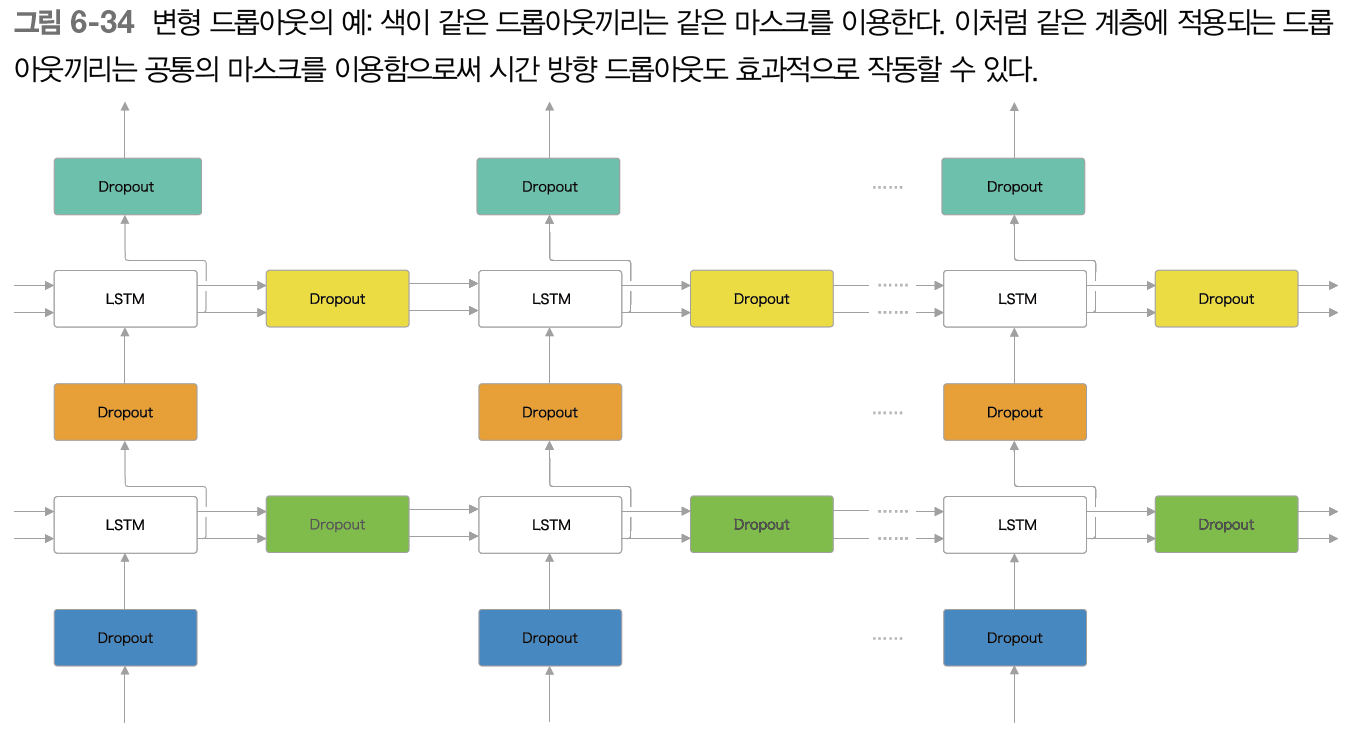

---




<br/><br/>


## 6.5.3.  가중치 공유 (효과)

### -  두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술

---

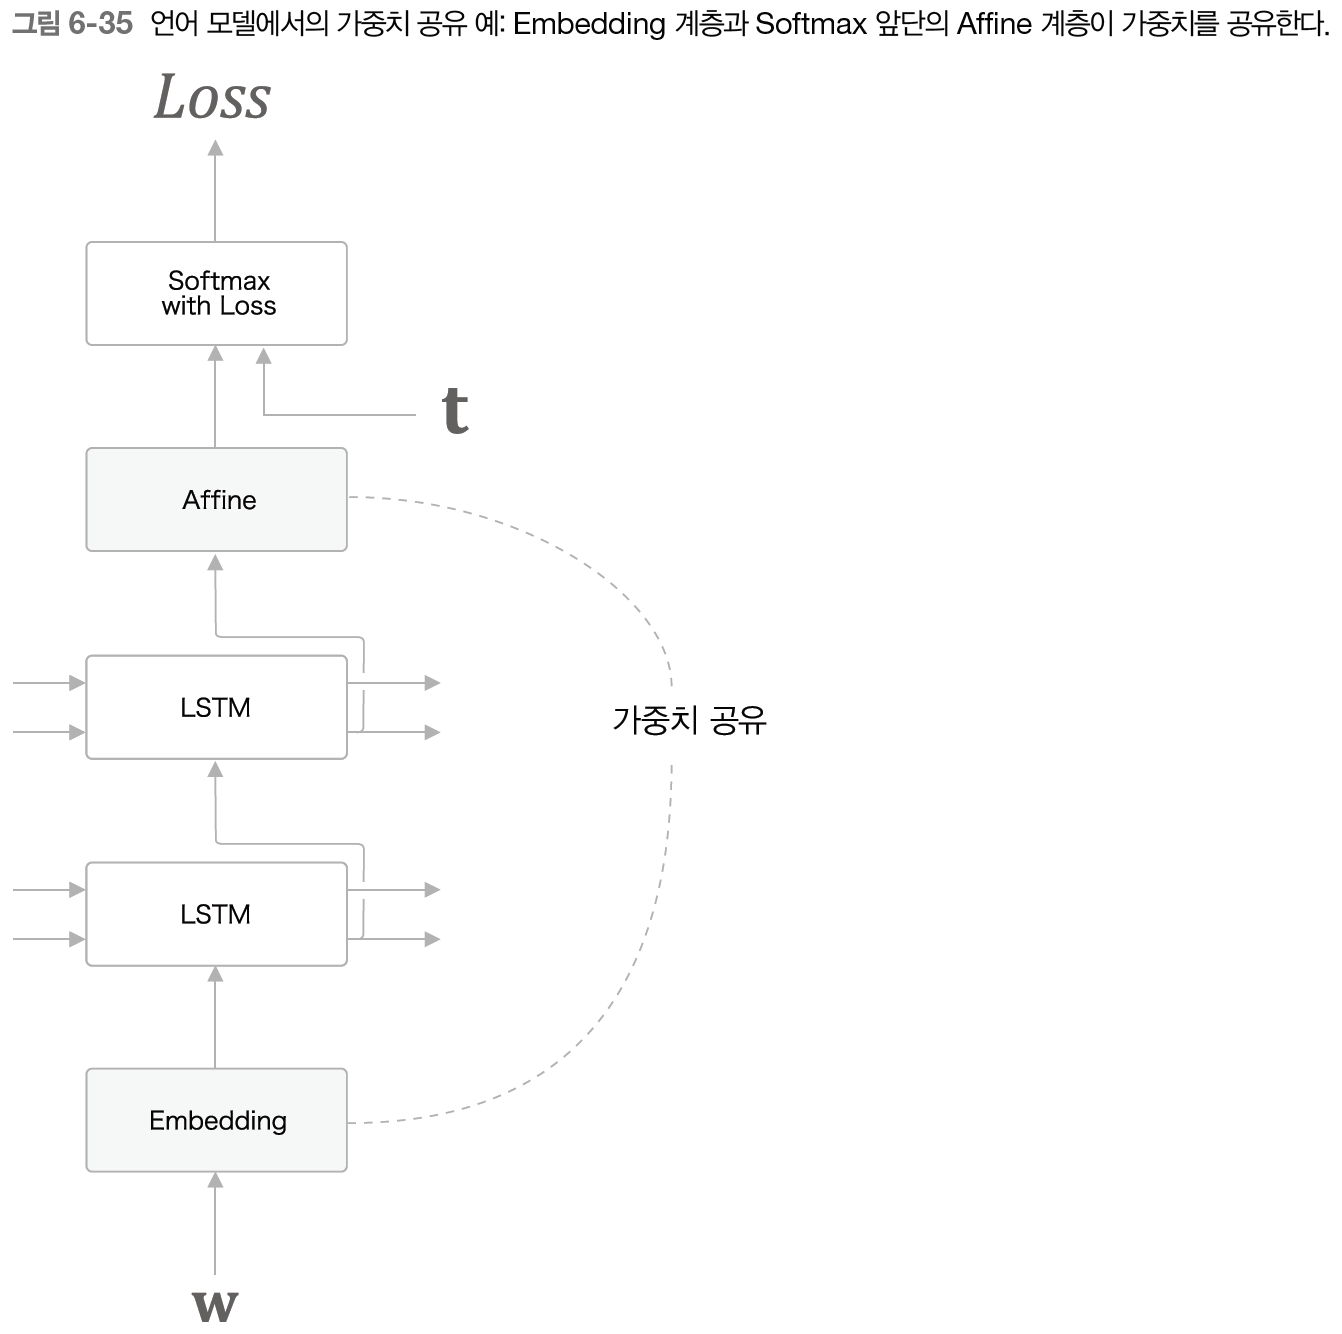

---

### -  [구현관점] 어휘수: V, LSTM의 은닉 상태의 차원수: H 일 때,
###     Embedding 계층의 가중치: VxH   ==(전치)=>  Affine 계층의 가중치: HxV  (간단한 설정으로 훌륭한 결과가 도출됨!!)



### - 매개변수 줄임 -> 학습 수월해짐 & 과적합 억제

<br/><br/><br/>

## 6.5.4. 개선된 RNNLM 구현

### * BetterRnnlm 클래스 구현 👇: 세가지 개선점 도입

**1. `LSTM 계층 다층화` - 여기에서는 2층**           
**2. `drop out에 의한 과적합 억제` - 깊이 방향으로만 적용**            
**3. `가중치 공유` - Embedding 계층과 Affine 계층에서 가중치 공유**

In [ ]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세가지 개선!! ---------------------------------------------------------------------
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),                              # dropout
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),  # 계층 쌓기(1)
            TimeDropout(dropout_ratio),                              # dropout
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),  # 계층 쌓기(2)
            TimeDropout(dropout_ratio),                              # dropout
            TimeAffine(embed_W.T, affine_b)  # weight tying!![가중치 공유 - 전치]
        ]
        # -----------------------------------------------------------------------------------
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

### (추가)  매 epoch에서 검증 데이터로 퍼플렉서티를 평가하고 => 그 값이 나빠졌을 경우에만 학습률 낮추기

### [ BetterRnnlm 클래스 - 학습 ]👇

In [ ]:
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# (추가 개선사항) 매 epoch에서 검증 데이터로 퍼플렉서티를 평가 --------------
best_ppl = float('inf')
for epoch in range(max_epoch):   
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, # 매 epoch마다 
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)  # 검증 데이터로 퍼플렉서티를 평가하고
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl: # 그 값(ppl)이 기존 퍼플렉시티(best_ppl)보다 높으면
        best_ppl = ppl 
        model.save_params()   # 파라미터에 저장하고
    else:
        lr /= 4.0      # 낮으면 학습률을 1/4로 줄임
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)
# ---------------------------------------------------------------------------

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

### <참고> eval_perplexity( ) 메서드 함수 코드 구현 

In [ ]:
import sys
sys.path.append('..')
import os
from common.np import *


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출
    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색
    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성
    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x